# Peaking test
This notebook uses the `EmissionsPeakTest` class, defined in the scripts section, to explore what level of reduction in Global Fossil CO2 emissions would be necessary to declare a peak with confidence.

Key steps are
- Load data into the EmissionsPeakTest class
- Characterise the noise (key choices here about whether to do the noise around a single trendline, or break the timeseries into a series of segments for analysis)
- Load test data for the future, and calculate the trendline for this data
- Do a bootstrap test to see how likely it is that outturn data with this trendline could actually be produced by a flat trend (H0 is that the trend=0), with just the noise contributing this variation

## Load packages

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Fossil co2 implementation

### Initialise peaker and characterise noise

In [3]:
peak_tester = EmissionsPeakTest(region='WLD')
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', year_range = range(1970,2024))

Loaded historical data: 1970-2023
Data points: 54


### Basic analysis
- Characterise noise
- Add test data and bootstrap
- Visualise results

In [4]:
peak_tester.characterize_noise(method='loess',noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()


using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 4.7
Autocorrelation analysis:
  Lag-1 autocorr: 0.393
  Residual σ (post-autocorrelation): 471.8
  Has significant autocorr: True
  Likelihood of autocorr: 0.9879633749956099
Noise characterization complete:
  Method used: loess
Using AR(1) noise generator with φ=0.393


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.ar1_noise_generator(size: int, initial_value: float | None = 0) -> numpy.ndarray>

In [5]:
# Testing that with a flat trend, it gives ~50% chance that emissions have actually peaked
peak_tester.set_test_data([
        (2024, peak_tester.historical_data.iloc[-1,1]),
        (2025, peak_tester.historical_data.iloc[-1,1]),
        (2026, peak_tester.historical_data.iloc[-1,1]), 
        (2027, peak_tester.historical_data.iloc[-1,1]),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')

Test data set: 2024-2027
Test slope: 0.00 Mt CO2 (R² = 1.000)
Recent historical trend: 236.65 Mt CO2
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.5095
  Significant at α=0.05: False
  Effect size: -0.02 standard deviations


In [6]:
# Testing what happens with a declining trend of 1% / yr
peak_tester.set_test_data([
        (2024, peak_tester.historical_data.iloc[-1,1]),
        (2025, peak_tester.historical_data.iloc[-1,1]*0.99),
        (2026, peak_tester.historical_data.iloc[-1,1]*0.99**2), 
        # (2027, peak_tester.historical_data.iloc[-1,1]*0.99**3),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')


Test data set: 2024-2026
Test slope: -374.26 Mt CO2 (R² = 1.000)
Recent historical trend: 236.65 Mt CO2
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.1425
  Significant at α=0.05: False
  Effect size: 0.98 standard deviations


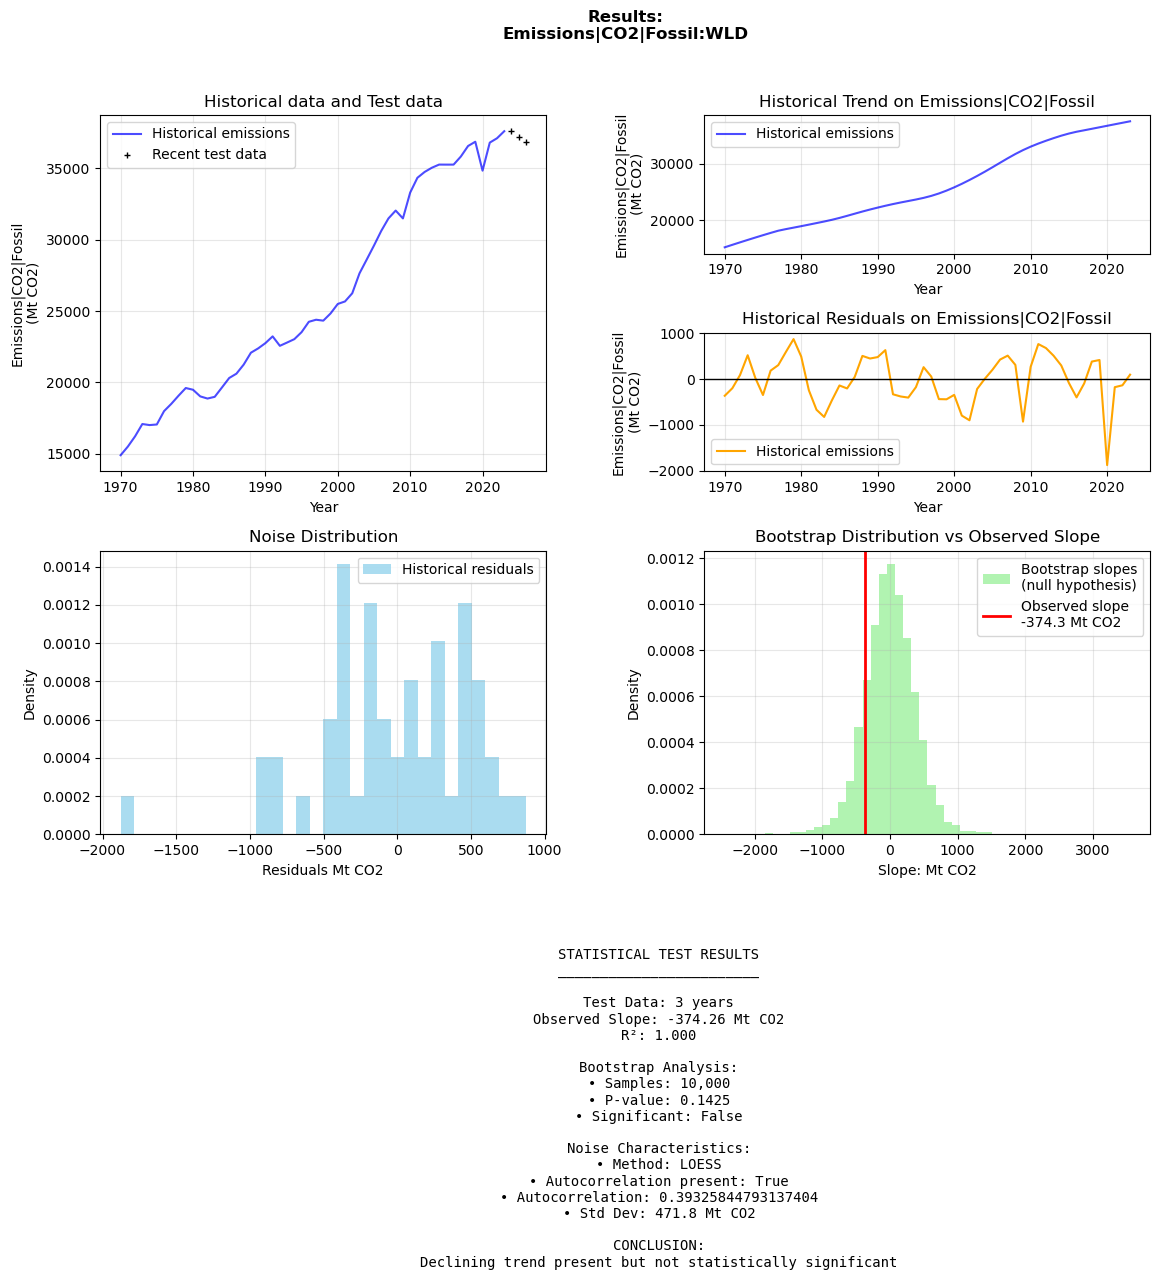

In [7]:
peak_tester.plot_analysis()

### Test impact of adding ignore_years

In [8]:
peak_tester.characterize_noise(method='hp')
peak_tester.characterize_noise(method='hp',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.386
  Residual σ (post-autocorrelation): 465.6
  Has significant autocorr: True
  Likelihood of autocorr: 0.9851878065099979
Noise characterization complete:
  Method used: hp
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.738
  Residual σ (post-autocorrelation): 328.5
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999999598451397
Noise characterization complete:
  Method used: hp


In [9]:
peak_tester.characterize_noise(method='loess')
peak_tester.characterize_noise(method='loess',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.393
  Residual σ (post-autocorrelation): 471.8
  Has significant autocorr: True
  Likelihood of autocorr: 0.9879633749956099
Noise characterization complete:
  Method used: loess
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.593
  Residual σ (post-autocorrelation): 321.9
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999233276002544
Noise characterization complete:
  Method used: loess


In [10]:
peak_tester.characterize_noise(method='hamilton')
peak_tester.characterize_noise(method='hamilton',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: -0.007
  Residual σ (post-autocorrelation): 633.1
  Has significant autocorr: False
  Likelihood of autocorr: 0.006011100851929796
Noise characterization complete:
  Method used: hamilton
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.086
  Residual σ (post-autocorrelation): 353.9
  Has significant autocorr: False
  Likelihood of autocorr: 0.3124426517719584
Noise characterization complete:
  Method used: hamilton


### Test impact of changing fraction for LOESS
Fraction is one of the main parameters in LOESS – how much of the time series do you use as the locally weighted regression? 

In [11]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [12]:
noise_params = []
peaking_likelihood = []

with HiddenPrints():
    for frac in np.linspace(0.1,0.9,17):
        (
            peak_tester
            .characterize_noise(method='loess',fraction=frac)
            .create_noise_generator()
        )
        (    peak_tester
            .set_test_data([
                (2025, 37700),
                (2026, 37580), 
                (2027, 37460),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )


        noise_params.append(peak_tester.autocorr_params)
        peaking_likelihood.append(peak_tester.bootstrap_results['p_value_one_tail'])
        

Text(0.5, 1.0, 'The impact of increasing fractions on the \nlikelihood that emissions have peaked')

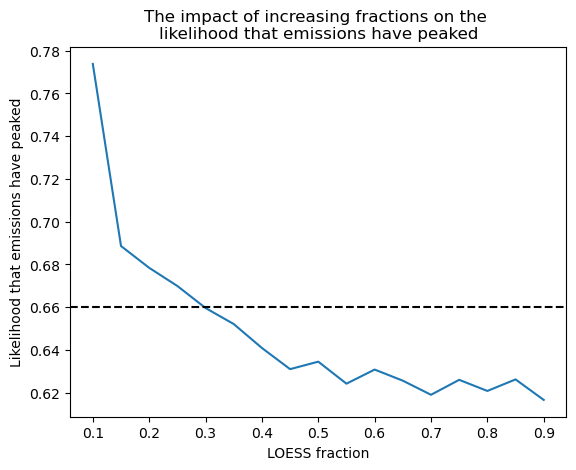

In [13]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[1-s for s in peaking_likelihood])
ax.set_ylabel('Likelihood that emissions have peaked')
ax.set_xlabel('LOESS fraction')
ax.axhline(y=0.66,color='k',ls='--')
ax.set_title('The impact of increasing fractions on the \nlikelihood that emissions have peaked')

# LOESS fraction of 0.1 ~= 5 year trend, 0.2 ~= 10 trends (with 54 data points)

Text(0.5, 1.0, 'The impact of increasing fractions \n on the estimate of noise')

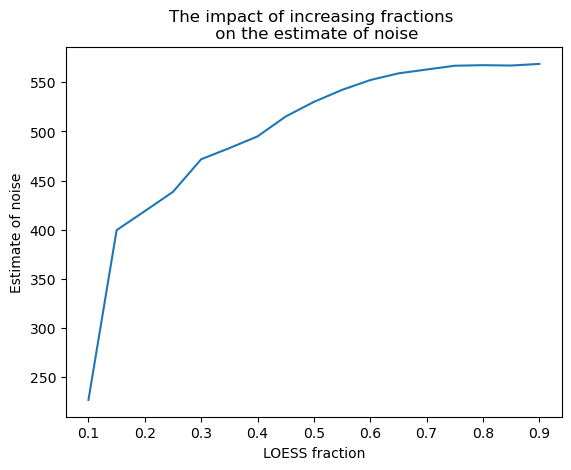

In [14]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[noise_params[i]['sigma_residuals'] for i in range(17)])
ax.set_ylabel('Estimate of noise')
ax.set_xlabel('LOESS fraction')
ax.set_title('The impact of increasing fractions \n on the estimate of noise')

# LOESS fraction of 0.1 ~= 5 year trend, 0.2 ~= 10 trends (with 54 data points)

## Testing impact of different noise distribution types

Loaded historical data: 1970-2014
Data points: 45


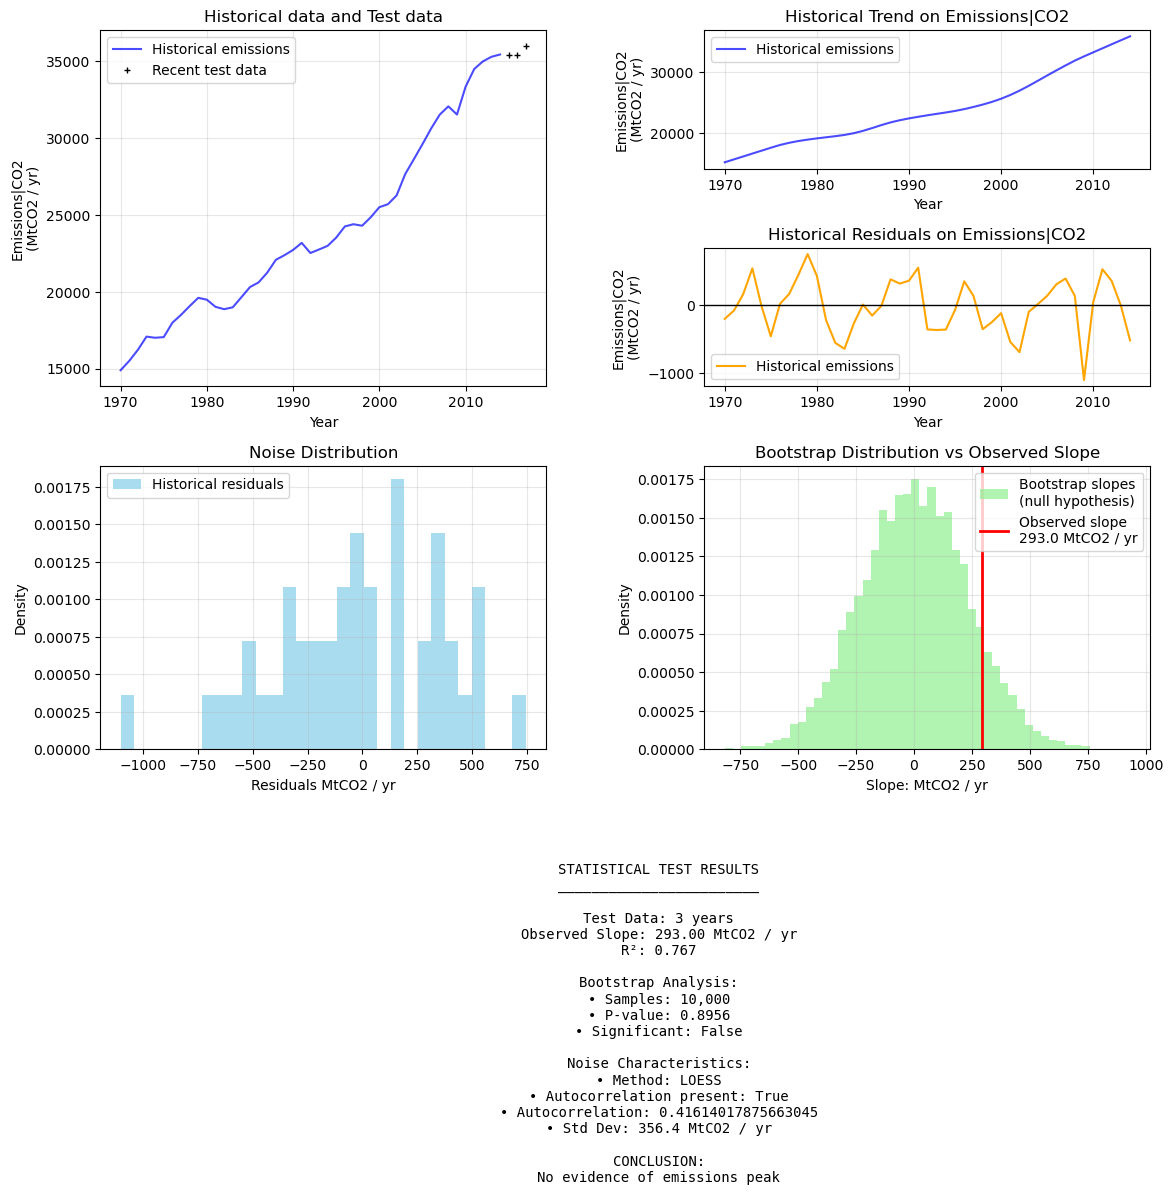

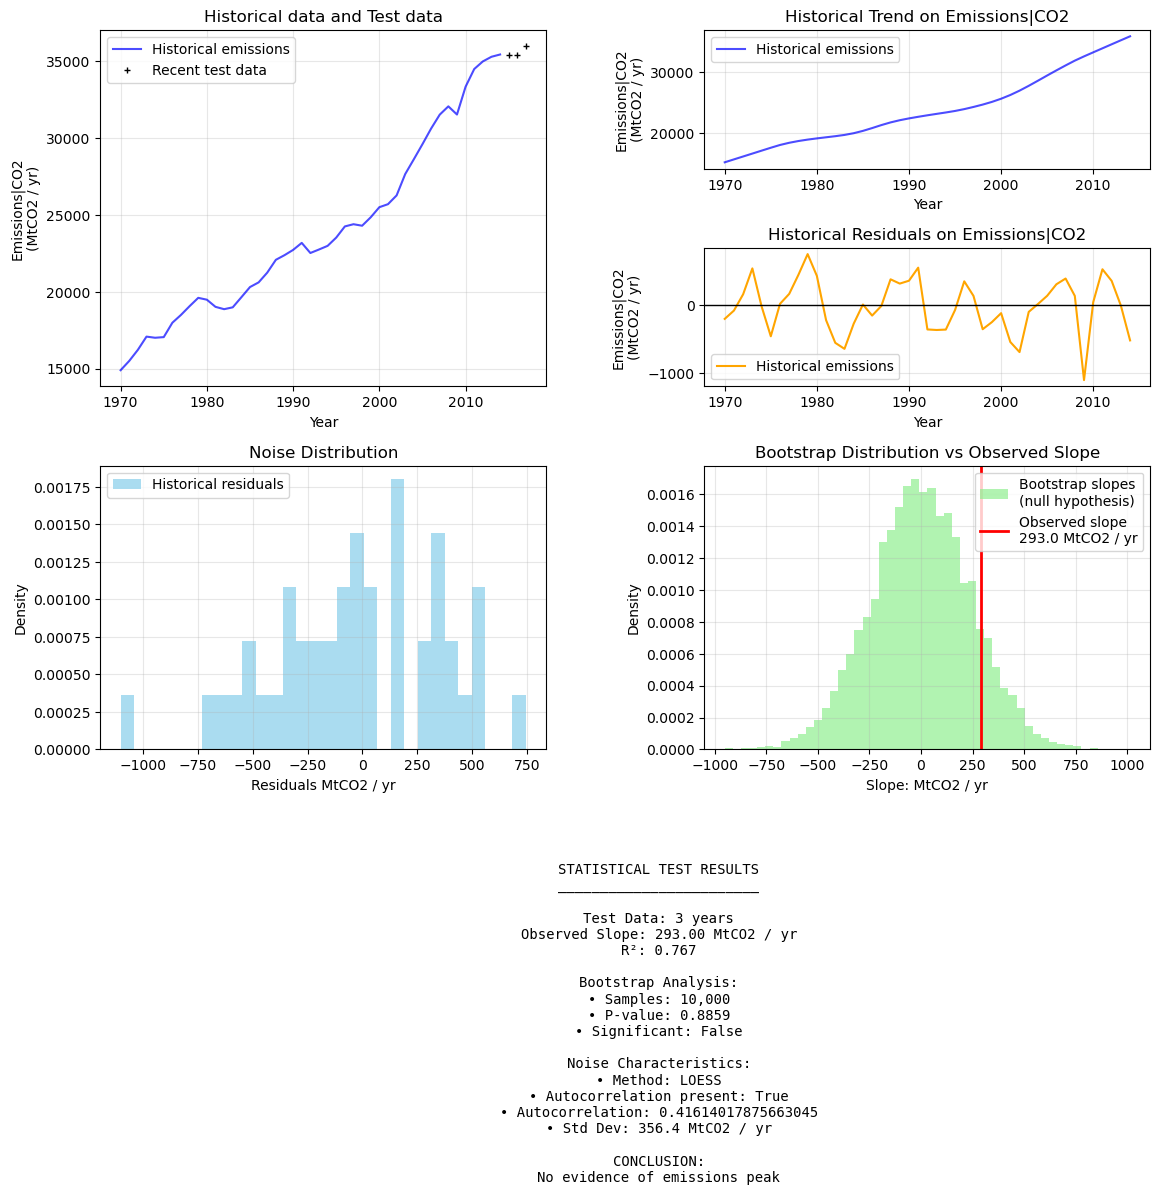

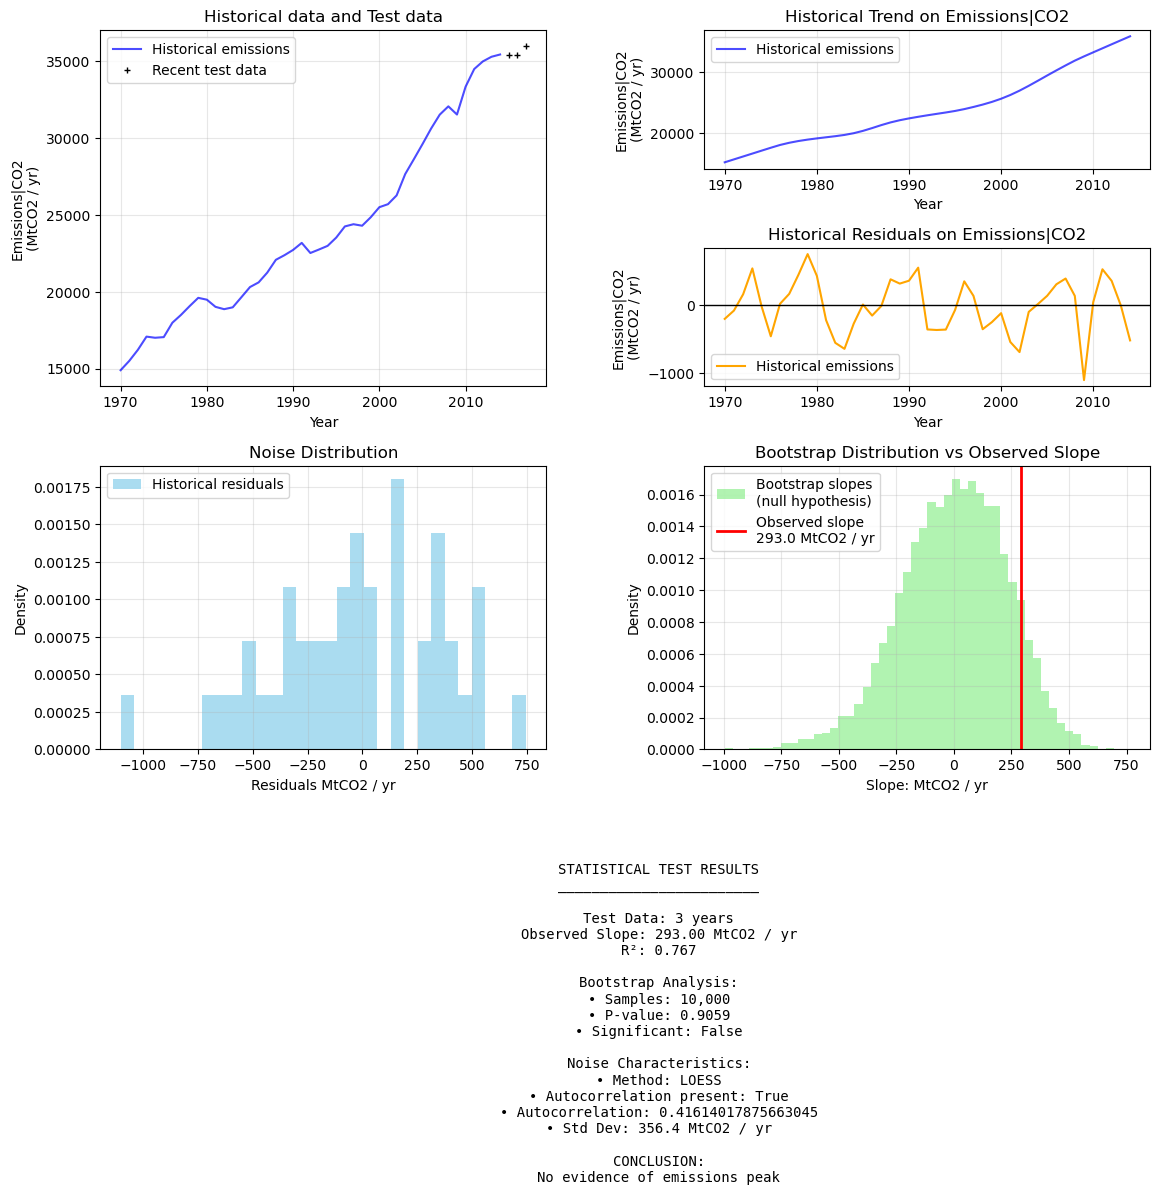

In [25]:
# Testing with data to 2014 and then 2015 and 2016 to see how likely it thinks peaking is - and the answer is not very :)
# t-distribution seems to be the most conservative.
noise_params = []
peaking_likelihood = []
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', year_range = range(1970,2015))

with HiddenPrints():
    for noise_type in ["normal", "t-dist", "empirical"]:
        (
            peak_tester
            .characterize_noise(method='loess',noise_type=noise_type)
            .create_noise_generator()
        )
        (    peak_tester
            .set_test_data([
                (2015, 35404),
                (2016, 35417),
                (2017, 35990)
                # (2017, 35200) # made up value for testing
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )
        peak_tester.plot_analysis()


        noise_params.append(peak_tester.autocorr_params)
        peaking_likelihood.append(peak_tester.bootstrap_results['p_value_one_tail'])
        

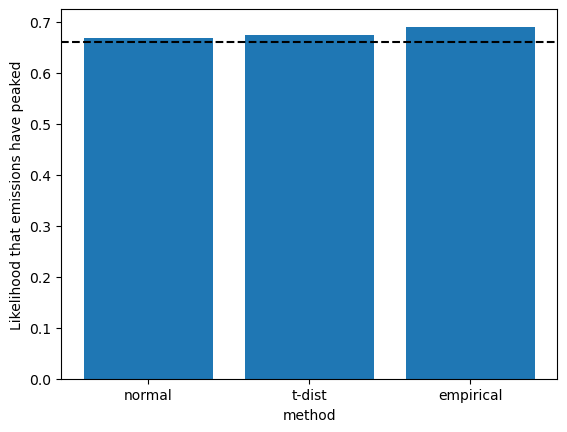

In [17]:
f, ax = plt.subplots()
ax.bar(["normal", "t-dist", "empirical"], [1-s for s in peaking_likelihood])
ax.set_ylabel('Likelihood that emissions have peaked')
ax.set_xlabel('method')
ax.axhline(y=0.66, color='k', ls='--')
# ax.set_title('The impact of increasing fractions on the \nlikelihood that emissions have peaked')


## Implementation on carbon intensity
Test applying the peak tester to carbon intensity instead, which abstracts out the GDP growth component

In [18]:
carbon_intensity_tester = EmissionsPeakTest()
carbon_intensity_tester.load_historical_data(
    'fossil_intensity.csv', year_range = range(1971,2024))

Loaded historical data: 1971-2023
Data points: 53


In [19]:
ci_noise_params = []
ci_peaking_likelihood = []

with HiddenPrints():
    for frac in np.linspace(0.1,0.9,17):
        (
            carbon_intensity_tester
            .characterize_noise(method='loess',fraction=frac)
            .create_noise_generator()
        )
        (    carbon_intensity_tester
            .set_test_data([
                (2025, 37700),
                (2026, 37580), 
                (2027, 37460),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )


        ci_noise_params.append(carbon_intensity_tester.autocorr_params)
        ci_peaking_likelihood.append(carbon_intensity_tester.bootstrap_results['p_value_one_tail'])
        

Text(0.5, 1.0, 'The impact of increasing fractions \n on the estimate of noise')

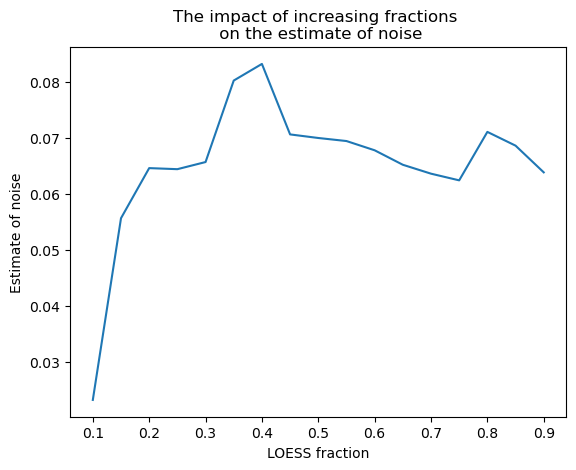

In [20]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[ci_noise_params[i]['sigma_residuals'] for i in range(17)])
ax.set_ylabel('Estimate of noise')
ax.set_xlabel('LOESS fraction')
ax.set_title('The impact of increasing fractions \n on the estimate of noise')

# LOESS fraction of 0.1 ~= 3 year trend, 0.2 ~= 6 trends (with ~30 data points)

Let's assume that GDP is growing at 2% per year over a three year period. Therefore we want to test if carbon intensity is falling more than 2% per year (which would be needed to offset a GDP growth trend)

In [21]:
carbon_intensity_tester.characterize_noise(method='loess',fraction=0.1).create_noise_generator()

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: -0.006
  Residual σ (post-autocorrelation): 0.0
  Has significant autocorr: False
  Likelihood of autocorr: 0.10318839950836867
Noise characterization complete:
  Method used: loess
Using white noise generator with σ=0.0


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.white_noise_generator(size: int, initial_value: float = 0) -> numpy.ndarray>

In [22]:
ci_2023 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2023,'emissions'].squeeze()

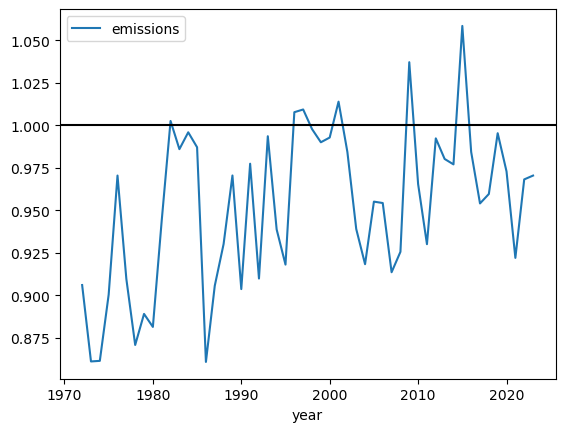

In [34]:
(carbon_intensity_tester.historical_data.set_index('year') / carbon_intensity_tester.historical_data.set_index('year').shift(1)).plot()
ax = plt.gca()
ax.axhline(y=1,color='k')

Test data set: 2025-2027
Test slope: -0.01 kgCO2 / $ (R² = 1.000)
Recent historical trend: -0.01 kgCO2 / $
Running complete bootstrap test...
  Null hypothesis: trend of -0.00706577408 / yr
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.3102
  Significant at α=0.05: False
  Effect size: 0.48 standard deviations


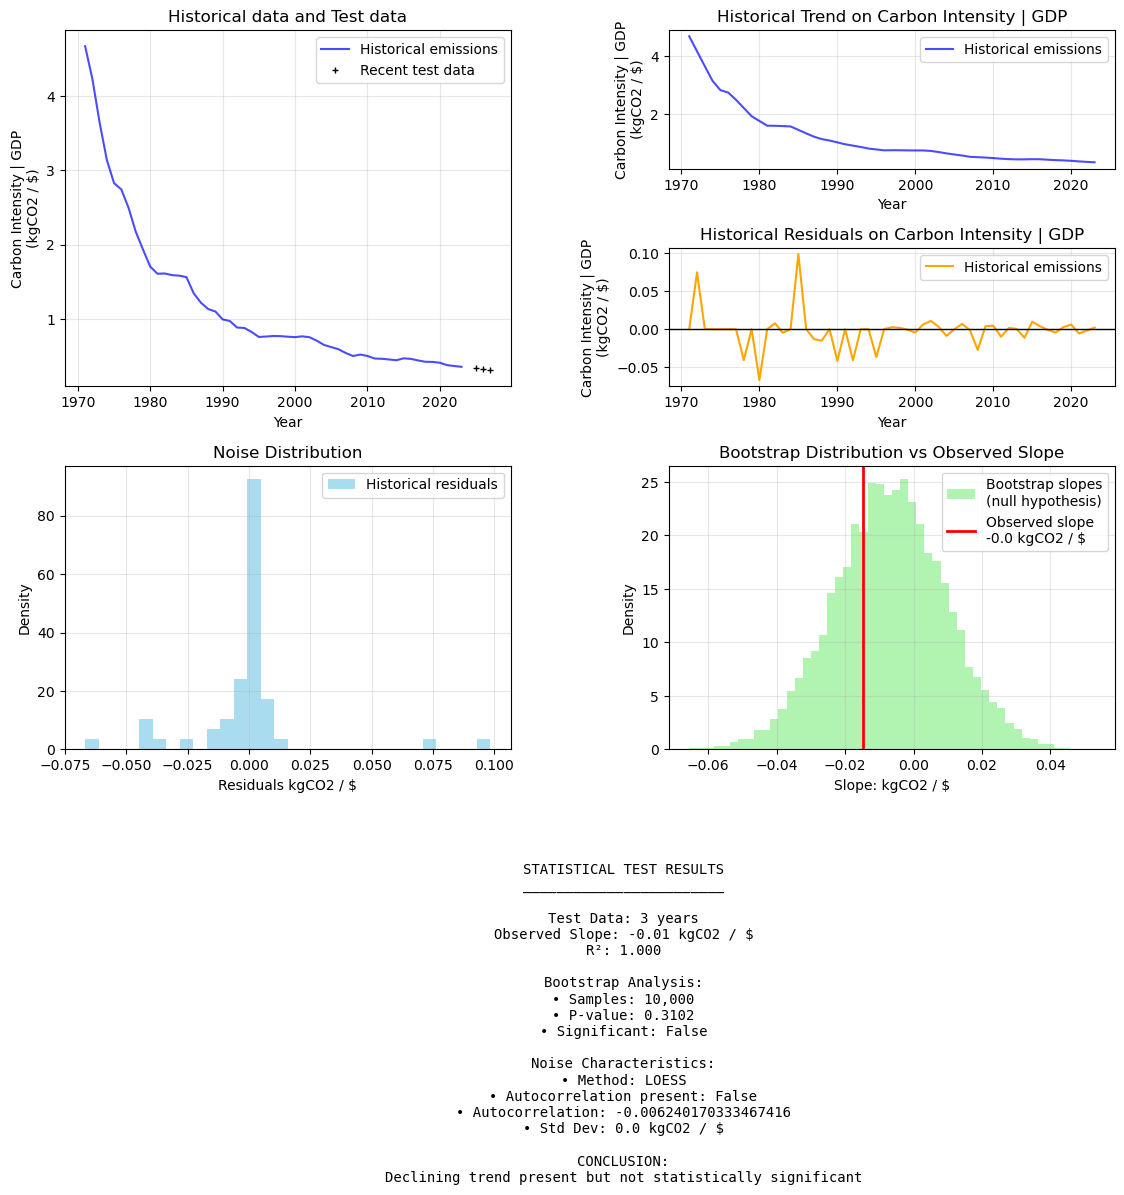

In [23]:

carbon_intensity_tester.set_test_data([
        (2025, ci_2023*0.955),
        (2026, ci_2023*0.955**2), 
        (2027, ci_2023*0.955**3),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis=ci_2023*-0.02)

carbon_intensity_tester.plot_analysis()